# Adversarial Validation


Before making our analysis on the train data, it is important to first verify that the train data is representative of the test data.

In [8]:
# fundamentals
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd 
import numpy as np
import scipy
import math

# catboost
import catboost as cb

# metrics for evaluation
from sklearn.metrics import mean_squared_error
from scipy import stats

# saving parameters
from joblib import dump, load

In [3]:
train = pd.read_csv('train.csv', index_col = 'id')

In [24]:
train.drop(columns = 'target', axis = 1, inplace=True)

In [25]:
train.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,dataset_label
id,,,,,,,,,,,,,,,,,,,,,
1,A,B,A,A,B,D,A,E,C,I,...,0.881122,0.421650,0.741413,0.895799,0.802461,0.724417,0.701915,0.877618,0.719903,0
2,B,A,A,A,B,B,A,E,A,F,...,0.440011,0.346230,0.278495,0.593413,0.546056,0.613252,0.741289,0.326679,0.808464,0
3,A,A,A,C,B,D,A,B,C,N,...,0.914155,0.369602,0.832564,0.865620,0.825251,0.264104,0.695561,0.869133,0.828352,0
4,A,A,A,C,B,D,A,E,G,K,...,0.934138,0.578930,0.407313,0.868099,0.794402,0.494269,0.698125,0.809799,0.614766,0
6,A,B,A,A,B,B,A,E,C,F,...,0.382600,0.705940,0.325193,0.440967,0.462146,0.724447,0.683073,0.343457,0.297743,0


In [26]:
test = pd.read_csv('test.csv', index_col='id')

In [27]:
train['dataset_label'] = 0
test['dataset_label'] = 1

categorical = ['cat0','cat1','cat2','cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9']

df_master = train.append(test)
final = pd.get_dummies(df_master,columns=categorical)
final = final.sample(frac=1)

In [28]:
def create_adversarial_data(df_master):
    df_master = df_master.sample(frac=1)
    adversarial_train = df_master[:len(train)]
    adversarial_test = df_master[len(train):]
    return adversarial_train, adversarial_test
    
adversarial_train, adversarial_test = create_adversarial_data(final)
adversarial_train.shape, adversarial_test.shape

((300000, 71), (200000, 71))

In [31]:
params = {
    'iterations': 500,
    'eval_metric': 'AUC'
}

train_data = cb.Pool(
    data=adversarial_train.drop('dataset_label',1),
    label=adversarial_train['dataset_label']
)
holdout_data = cb.Pool(
    data=adversarial_test.drop('dataset_label',1),
    label=adversarial_test['dataset_label']
)


"""
Training Classification model for Master Data
"""

model = cb.CatBoostClassifier(**params)
AdVi_history = model.fit(train_data, eval_set=holdout_data, plot=False, verbose=False)

In [32]:
from catboost.utils import get_roc_curve

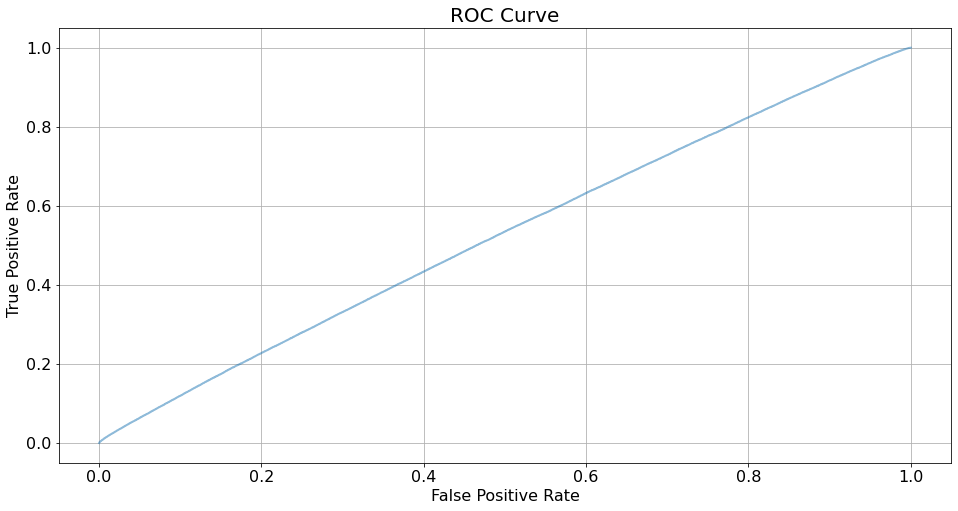

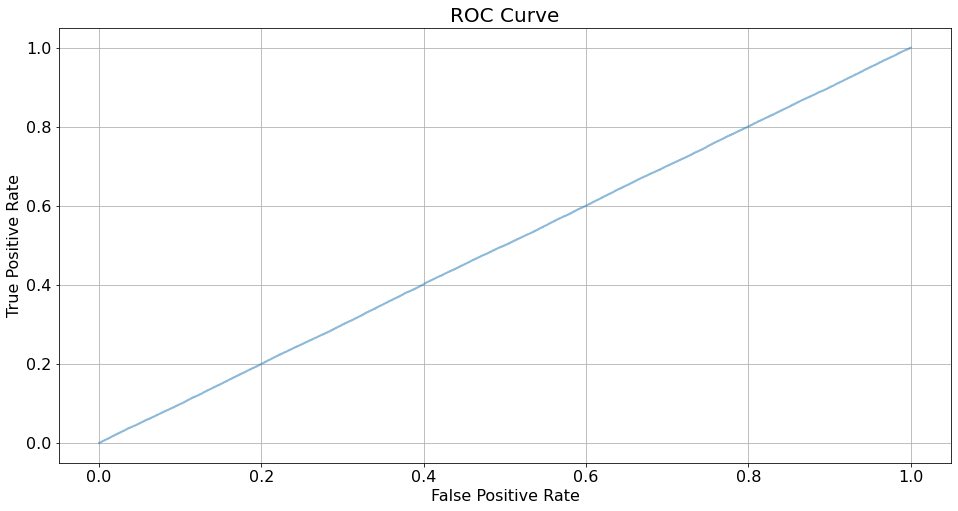

(array([0.00000000e+00, 8.32840569e-06, 1.66568114e-05, ...,
        9.99991672e-01, 1.00000000e+00, 1.00000000e+00]),
 array([0.        , 0.        , 0.        , ..., 0.99998749, 0.99998749,
        1.        ]),
 array([1.        , 0.52003407, 0.51572396, ..., 0.30868851, 0.30079939,
        0.        ]))

In [30]:
get_roc_curve(model, 
              train_data,
              thread_count=-1,
              plot=True)

get_roc_curve(model, 
              holdout_data,
              thread_count=-1,
              plot=True)

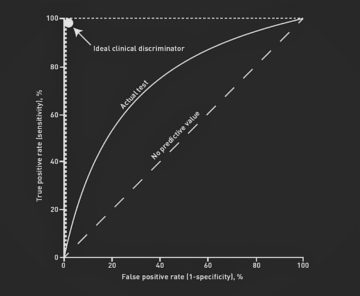

Based on the ROC Curve, we can see that no predictive value is shown from the model. This means that the model has no power to distinguish between the train data and the test data. Thus, the train data is a good representation of the test data. 